This version splits by baby. jaundice is still leading but it is at least spread out to more variables. also uses predict proba

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">Proposed Method</div>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Loading Files</div>

In [22]:
# load the data frame
df = pd.read_csv('historical.csv')
fn_details = pd.read_csv('corrected_false_negatives.csv')

In [23]:
df.iloc[:,9:]

,weight_kg,length_cm,head_circumference_cm,temperature_c,heart_rate_bpm,respiratory_rate_bpm,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level
0,3.28,50.1,32.0,37.0,160,36,98,Formula,11,9,0,4.2,7.0,Yes,Yes,At Risk
1,3.35,50.2,32.0,37.2,156,40,99,Formula,11,5,2,10.6,NaN,No,No,At Risk
2,3.35,50.6,32.1,37.1,137,37,97,Breastfeeding,7,6,5,9.8,NaN,No,No,Healthy
3,3.48,50.3,32.0,37.4,130,33,97,Mixed,11,8,4,8.1,NaN,No,Yes,Healthy
4,3.50,50.3,31.8,36.8,138,39,96,Breastfeeding,11,7,1,11.6,NaN,No,Yes,At Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,4.99,52.5,34.8,37.1,141,36,98,Mixed,8,8,2,2.5,NaN,No,Yes,Healthy
2096,5.04,52.6,34.6,36.8,138,34,98,Mixed,7,8,4,3.3,NaN,No,Yes,Healthy
2097,5.05,52.9,34.9,37.3,131,46,97,Mixed,11,6,2,3.2,NaN,No,Yes,Healthy
2098,5.03,52.9,34.8,37.0,133,45,98,Mixed,10,5,5,3.2,NaN,No,Yes,Healthy


In [24]:
# get complete columns for false negative babies
fn_df = fn_details.merge(df, 
                         on=fn_details.columns.tolist(), 
                         how='left')

In [25]:
# ----------- STEP 1: Define Feature Types -----------
# Sepeparate features by data types
numerical_features_std = ['weight_kg', 'length_cm',
                     'head_circumference_cm', 'temperature_c', 'heart_rate_bpm', 'respiratory_rate_bpm',
                     'oxygen_saturation', 'jaundice_level_mg_dl']

numerical_features_minmax = ['age_days', 'feeding_frequency_per_day','urine_output_count',
                             'stool_count']

numerical_features = numerical_features_std + numerical_features_minmax
categorical_features = ['feeding_type']

binary_features = ['gender','immunizations_done', 'reflexes_normal']
for col in binary_features:
    df[col] = (
        df[col]
        .astype(str)
        .str.lower()
        .map({'yes': 1, 'male': 1, 'no': 0, 'female': 0})
        .fillna(0)
        .astype(int)  # ensure numeric dtype
    )
    
drop_col = ['baby_id', 'name', 'date', 'gestational_age_weeks', 'birth_weight_kg', 
                     'birth_length_cm', 'birth_head_circumference_cm','apgar_score']
df['risk_level'] = df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values

/tmp/ipykernel_75295/1555873600.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['risk_level'] = df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values


In [26]:
# Get unique babies
unique_babies = df['baby_id'].unique()

# Split babies, not records
Train_babies, test_babies = train_test_split(
    unique_babies, test_size=0.15, random_state=0
)

# Split babies, not records
train_babies, val_babies = train_test_split(
    Train_babies, test_size=0.15, random_state=0
)

# Filter dataframe
train_df = df[df['baby_id'].isin(train_babies)].copy()
val_df = df[df['baby_id'].isin(val_babies)].copy()
test_df = df[df['baby_id'].isin(test_babies)].copy()

# Now fill within each set
train_df['apgar_score'] = train_df.groupby('baby_id')['apgar_score'].ffill()
val_df['apgar_score'] = val_df.groupby('baby_id')['apgar_score'].ffill()
test_df['apgar_score'] = test_df.groupby('baby_id')['apgar_score'].ffill()

X_train = train_df.drop(columns='risk_level')
X_train = X_train.drop(columns=drop_col)
y_train = train_df['risk_level']

X_val = val_df.drop(columns='risk_level')
X_val = X_val.drop(columns=drop_col)
y_val = val_df['risk_level']

X_test = test_df.drop(columns='risk_level')
X_test = X_test.drop(columns=drop_col)
y_test = test_df['risk_level']

In [27]:
# ----------- STEP 3: Preprocessing Pipeline -----------

lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num_std', 'passthrough', numerical_features_std),
        ('num_minmax', 'passthrough', numerical_features_minmax),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)  # binary features are left untouched
    ]
)

rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num_std', 'passthrough', numerical_features_std),
        ('num_minmax', 'passthrough', numerical_features_minmax),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)  # binary features are left untouched
    ]
)

preprocessors = {
    'Logistic Regression (L2)': lr_preprocessor,
    'Logistic Regression (L1)': lr_preprocessor,
    'Random Forest': rf_preprocessor
}

# Parameter grids for hyperparameter tuning
params = {
    'Logistic Regression (L2)': {
        'smote__k_neighbors': [3, 5, 7],
        'clf__C': [1e-3, 1e-2, 1e-1, 1],
    },
    'Logistic Regression (L1)': {
        'smote__k_neighbors': [3, 5, 7],
        'clf__C': [1e-3, 1e-2, 1e-1, 1],
    },
    'Random Forest': {
        'smote__k_neighbors': [3, 5, 7],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [1, 2, 3],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
}

models = {
    'Logistic Regression (L2)': LogisticRegression(penalty = 'l2', max_iter=1000, solver='liblinear', random_state=42),
    'Logistic Regression (L1)': LogisticRegression(penalty = 'l1', max_iter=1000, solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

In [28]:
# get best model and hyperparameters using validation set
results = []
trained_models = {}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")

    # Fit preprocessor to get categorical feature indices
    preprocessor = preprocessors[name].fit(X_train)
    feature_names_out = preprocessor.get_feature_names_out()
    
    numerical_count = len(numerical_features)
    new_categorical_features = preprocessor.named_transformers_['cat']
    categorical_count = len(new_categorical_features.get_feature_names_out())
    binary_count = len(binary_features)
    indices = list(range(numerical_count, numerical_count + categorical_count + binary_count))
    print(numerical_count, categorical_count, binary_count)

    pipe = imb_pipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTENC(categorical_features=indices,
                          random_state=42)),
        ("clf", model)
        
    ])
    
    rcv = RandomizedSearchCV(pipe, params[name], 
                             random_state=0, scoring='recall', cv=kfold)
    search = rcv.fit(X_train, y_train)
    
    best_params = search.best_params_
    best_model = search.best_estimator_
    print(best_params)
    trained_models[name] = best_model

    threshold = 0.5
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    
    y_train_pred = (y_train_proba >= threshold).astype(int)
    y_val_pred = (y_val_proba >= threshold).astype(int)
    
    results.append({
        'Model': name,
        'Train_Acc': accuracy_score(y_train, y_train_pred),
        'Val_Acc': accuracy_score(y_val, y_val_pred),
        'Train_F1': f1_score(y_train, y_train_pred),
        'Val_F1': f1_score(y_val, y_val_pred),
        'Train_Precision': precision_score(y_train, y_train_pred),
        'Val_Precision': precision_score(y_val, y_val_pred),
        'Train_Recall': recall_score(y_train, y_train_pred),
        'Val_Recall': recall_score(y_val, y_val_pred),
    })

# ----------- STEP 6: Show Results -----------

results_df = pd.DataFrame(results).sort_values(by='Val_Recall', ascending=False).reset_index(drop=True)
print(results_df)


Training: Logistic Regression (L2)
{'smote__k_neighbors': 7, 'clf__C': 0.001}

Training: Logistic Regression (L1)
{'smote__k_neighbors': 7, 'clf__C': 0.1}

Training: Random Forest
{'smote__k_neighbors': 3, 'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_depth': 3}
                      Model  Train_Acc   Val_Acc  Train_F1    Val_F1  \
0             Random Forest      0.992  0.981481  0.969388  0.929577   
1  Logistic Regression (L2)      0.892  0.881481  0.674699  0.644444   
2  Logistic Regression (L1)      0.904  0.888889  0.694915  0.615385   

   Train_Precision  Val_Precision  Train_Recall  Val_Recall  
0         0.984456       0.970588      0.954774    0.891892  
1         0.561873       0.547170      0.844221    0.783784  
2         0.600733       0.585366      0.824121    0.648649  


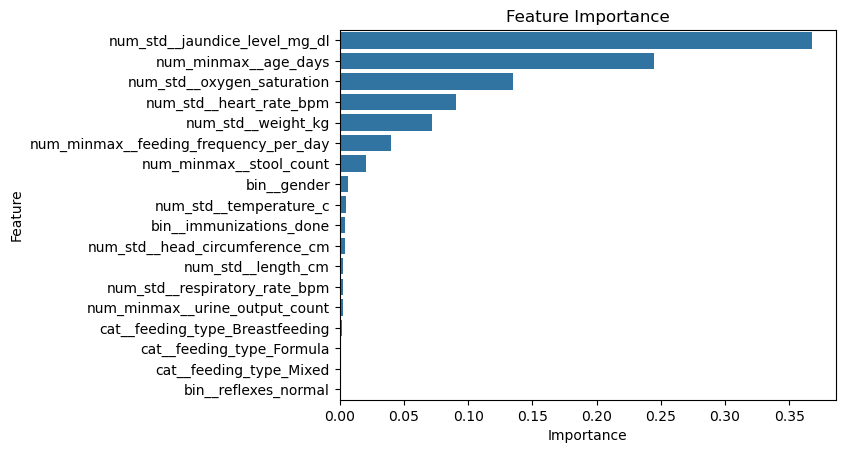

In [29]:
best_pipe = trained_models[results_df.loc[0,'Model']]
best_model = best_pipe.named_steps['clf']

best_pipe.fit(X_train, y_train)

FEATURE_NAMES_NEW = preprocessor.get_feature_names_out()
feature_importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': FEATURE_NAMES_NEW,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [20]:
# See result of best model on test set
y_train_proba = best_pipe.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= threshold).astype(int)

y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       288
           1       0.89      0.95      0.92        42

    accuracy                           0.98       330
   macro avg       0.94      0.97      0.95       330
weighted avg       0.98      0.98      0.98       330

     0   1
0  283   5
1    2  40
